<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Forward Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>September 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@fr.ey.com</span>
</p>
</CENTER>

In this notebook, we analyze in details different methods for the regression of conditional raw moments. This is of most importance as it is the first brick of the GLSMC and JLSMC methods.

## <span id="section-0" style="color:#00B8DE"> 0 - Imports </span>

In [7]:
import  numpy                       as      np
import  matplotlib.pyplot           as      plt
from    backend.utils               import  TimeGrid, get_mtmdiff_nmc, get_centred_moms, get_skewkurt, get_mtmdiff
from    backend.regressors          import  RawMomentsRegressor
from    backend.pricing_models      import  BlackScholes, YieldCurve, OneFactorHullWhite
from    backend.pricing_engines     import  PutBlackScholes, SwaptionOneFactorHullWhite
from    backend.forward_im_models   import  JohnsonLeastSquaresMonteCarlo

In [8]:
np.random.seed(0)
plt.style.use('ggplot')
color_jlsmc     = 'blue'
color_glsmc     = 'red'
color_invalid   = 'purple'
jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

num_paths   = 10000
maturity    = 1
time_grid   = TimeGrid(1/240, maturity)
alpha       = 0.99
mpor        = 1/24

## <span id="section-0" style="color:#00B8DE"> I - Generating risk factors and portfolio price paths of interest </span>

Let us first define our risk factors and portfolio, and compute the associated paths. Uncomment/comment the first/second block to use either case study.

In [9]:

spot = 100
risk_factor = BlackScholes(0.3, 0.05, spot)
portfolio   = PutBlackScholes(95, maturity, risk_factor)
'''
yield_curve = YieldCurve(0.05, -0.03, -0.18)
spot = yield_curve.zero_coupon_yield(0)
risk_factor = OneFactorHullWhite(0.01, 0.015, yield_curve)
portfolio   = SwaptionOneFactorHullWhite(maturity, 0.04, TimeGrid(0.25, 4.75), 10000, risk_factor)
'''
risk_factor.set_time_grid(time_grid)
risk_factor_paths   = risk_factor.generate_paths(num_paths)
mtm_paths           = portfolio.generate_paths(risk_factor_paths)
mtmdiff_paths       = get_mtmdiff(mtm_paths, mpor, time_grid)

Now, we define how are calculated the support values.

In [10]:
support_values_setting          = {'initial nb': 100, 'perc add tails': 0.1, 'add ends': False}
q_all = JohnsonLeastSquaresMonteCarlo(alpha, mpor, time_grid, None, support_values_setting, None).get_percent_values()

Next, we compute all the risk factors values and portfolio prices that will be used in the analysis at $t_\text{ref}$.

In [11]:
tref        = 1/12 # reference time for analyzing the moments regression
ind_tref    = time_grid.find_index(tref)
risk_factor_train   = risk_factor_paths[:, ind_tref]
mtm_train           = mtm_paths[:, ind_tref]
mtm_func            = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000) # for plotting
mtm_supp            = np.quantile(mtm_train, q_all, method='inverted_cdf') # support values

num_paths_test          = 100
num_nested_paths_test   = 100000
risk_factor_test        = np.linspace(np.min(risk_factor_train), np.max(risk_factor_train), num_paths_test) # for plotting nested MC results
risk_factor.set_time_grid(TimeGrid(time_grid.timestep, 0, tref))
mtm_test = portfolio.generate_paths(risk_factor_test.reshape(-1, 1)).reshape(-1) # associated mtm values
risk_factor.set_time_grid(time_grid)

mtmdiff_nmc_test    = get_mtmdiff_nmc(num_nested_paths_test, portfolio, risk_factor_test, mtm_test, mpor, tref)
muraw_test          = np.column_stack([np.mean(mtmdiff_nmc_test**i, axis=1) for i in range(1, 5)]) # "true" raw moments computed via nested MC
mu_test                         = get_centred_moms(muraw_test)[0] # "true" centred moments
skew_test, kurt_test, _, _, _   = get_skewkurt(mu_test) # "true" skewness and kurtosis

Now, you can choose a regression setting for estimating conditional raw moments.

In [12]:
settings_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': True},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': True},
    {'id': 2, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'basis_type': 'laguerre', 'order': 7, 'regress_mean': True},
    {'id': 3, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': True},
    {'id': 4, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': True},
    {'id': 5, 'method': 'KR', 'bandwidth': 'silverman', 'regress_mean': True},
    {'id': 6, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False},
    {'id': 7, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': False},
    {'id': 8, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'basis_type': 'laguerre', 'order': 7, 'regress_mean': False},
    {'id': 9, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False},
    {'id': 10, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': False},
    {'id': 11, 'method': 'KR', 'bandwidth': 'silverman', 'regress_mean': False},
]

setting = settings_list[0]

In [13]:
y_train = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, 5)
moments_regressor = RawMomentsRegressor(setting, 4)
moments_regressor.fit(mtm_train, y_train)
murawhat_test    = moments_regressor.predict(mtm_test)
murawhat_func    = moments_regressor.predict(mtm_func)
murawhat_supp    = moments_regressor.predict(mtm_supp)
muhat_test, maskhat_test    = get_centred_moms(murawhat_test)
muhat_func, maskhat_func    = get_centred_moms(murawhat_func)
muhat_supp, maskhat_supp    = get_centred_moms(murawhat_supp)
skewhat_test, kurthat_test, mask_skewhat_test, mask_kurthat_test, mask_tothat_test        = get_skewkurt(muhat_test, maskhat_test)
skewhat_func, kurthat_func, mask_skewhat_func, mask_kurthat_func, mask_tothat_func        = get_skewkurt(muhat_func, maskhat_func)
skewhat_supp, kurthat_supp, mask_skewhat_supp, mask_kurthat_supp, mask_tothat_supp        = get_skewkurt(muhat_supp, maskhat_supp)

Let us plot the conditional raw moments estimated.

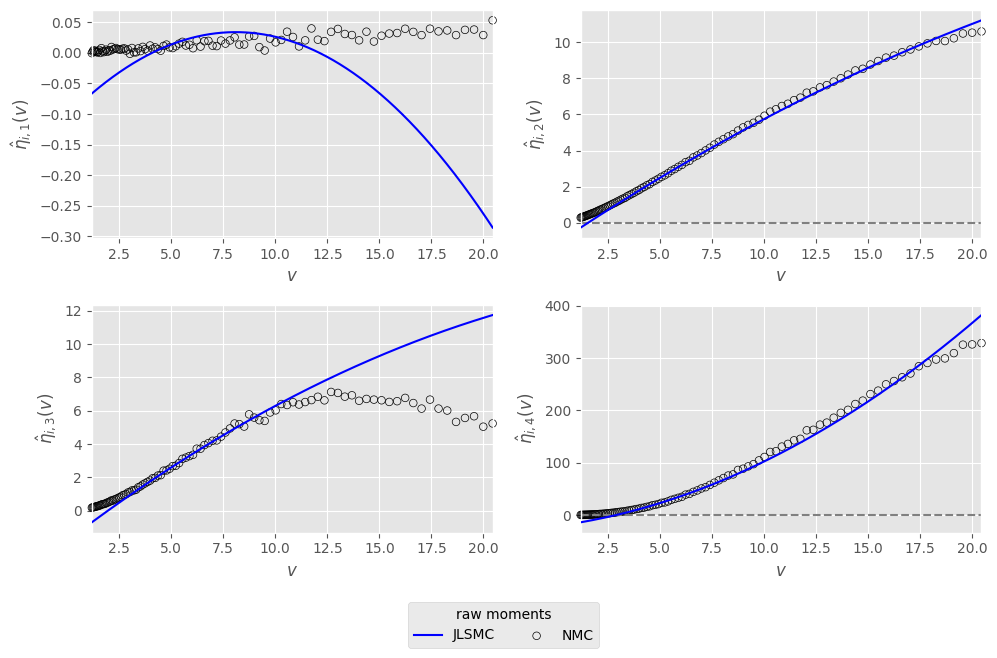

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, murawhat_func[:, 0], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, muraw_test[:, 0], color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$\\hat \\eta_{i, 1}(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, murawhat_func[:, 1], color=color_jlsmc, zorder=3)
axs[0, 1].scatter(mtm_test, muraw_test[:, 1], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$\\hat \\eta_{i, 2}(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, murawhat_func[:, 2], color=color_jlsmc, zorder=3)
axs[1, 0].scatter(mtm_test, muraw_test[:, 2], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$\\hat \\eta_{i, 3}(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, murawhat_func[:, 3], color=color_jlsmc, zorder=3)
axs[1, 1].scatter(mtm_test, muraw_test[:, 3], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$\\hat \\eta_{i, 4}(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
plt.show()

Then, let us plot the conditional centred moments. Notice that we have invalid support values corresponding to support values for which metrics values are outside their domain definition. Hence, these invalid support values should be removed from further computations. The support quantiles associated to invalid support values are set to zero only to visualize them on the graphs.

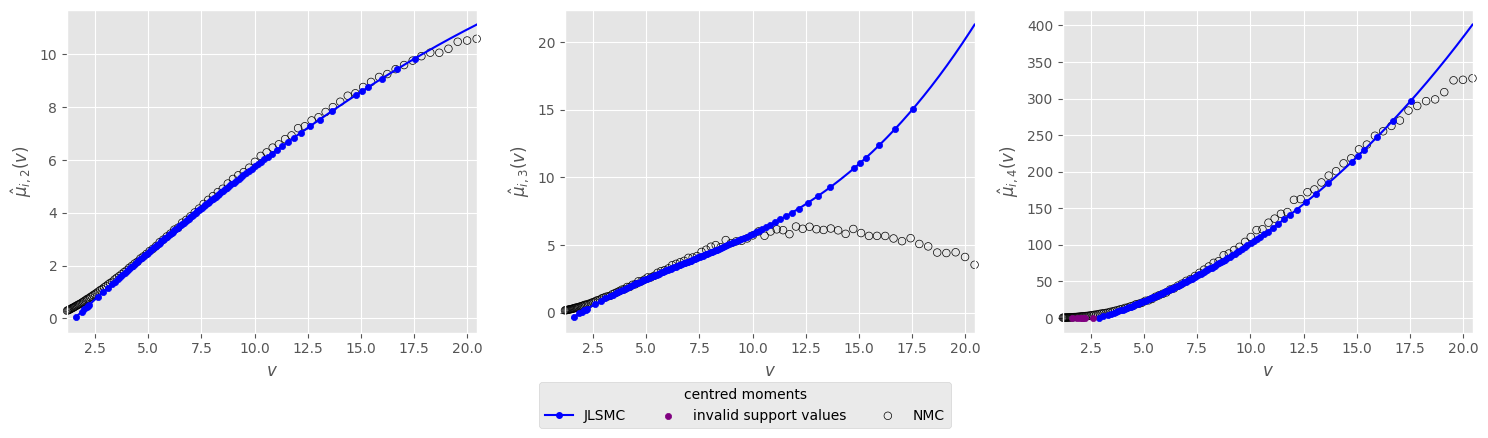

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[maskhat_func[:, 0]], muhat_func[maskhat_func[:, 0], 0], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[maskhat_supp[:, 0]], muhat_supp[maskhat_supp[:, 0], 0], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~maskhat_supp[:, 0]], np.zeros_like(mtm_supp[~maskhat_supp[:, 0]]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, mu_test[:, 0], color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\hat \\mu_{i, 2}(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[maskhat_func[:, 1]], muhat_func[maskhat_func[:, 1], 1], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[maskhat_supp[:, 1]], muhat_supp[maskhat_supp[:, 1], 1], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~maskhat_supp[:, 1]], np.zeros_like(mtm_supp[~maskhat_supp[:, 1]]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu_test[:, 1], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\hat \\mu_{i, 3}(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[maskhat_func[:, 2]], muhat_func[maskhat_func[:, 2], 2], color=color_jlsmc, zorder=3)
axs[2].scatter(mtm_supp[maskhat_supp[:, 2]], muhat_supp[maskhat_supp[:, 2], 2], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~maskhat_supp[:, 2]], np.zeros_like(mtm_supp[~maskhat_supp[:, 2]]), color=color_invalid, s=20, zorder=3)
axs[2].scatter(mtm_test, mu_test[:, 2], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\hat \\mu_{i, 4}(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
plt.show()

Let us display the estimated conditional skewness and kurtosis.

Total nummber of invalid support points: 7


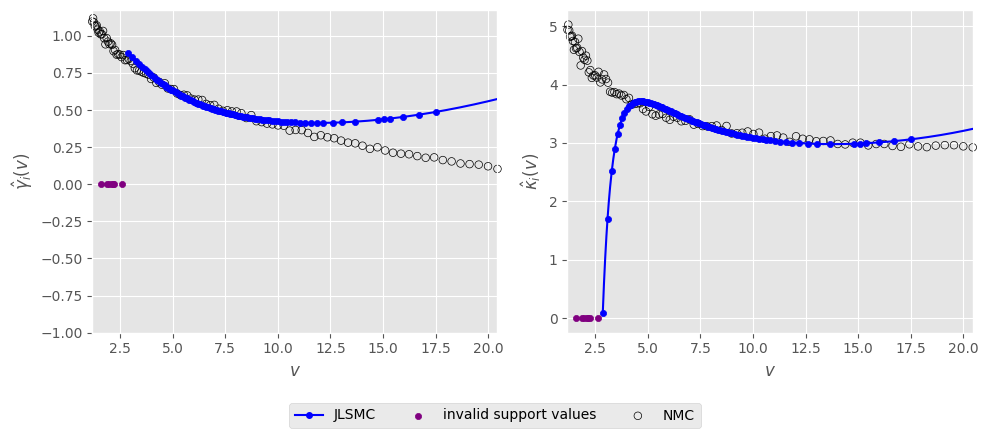

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_tothat_func], skewhat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp], skewhat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\hat \\gamma_i(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_tothat_func], kurthat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp], kurthat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\hat \\kappa_i(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp)}")

plt.tight_layout()
plt.show()

Finally, we plot all the metrics that will be used for the Johnson distribution fitting, through moment matching (algorithm AS99).

Total nummber of invalid support points: 7


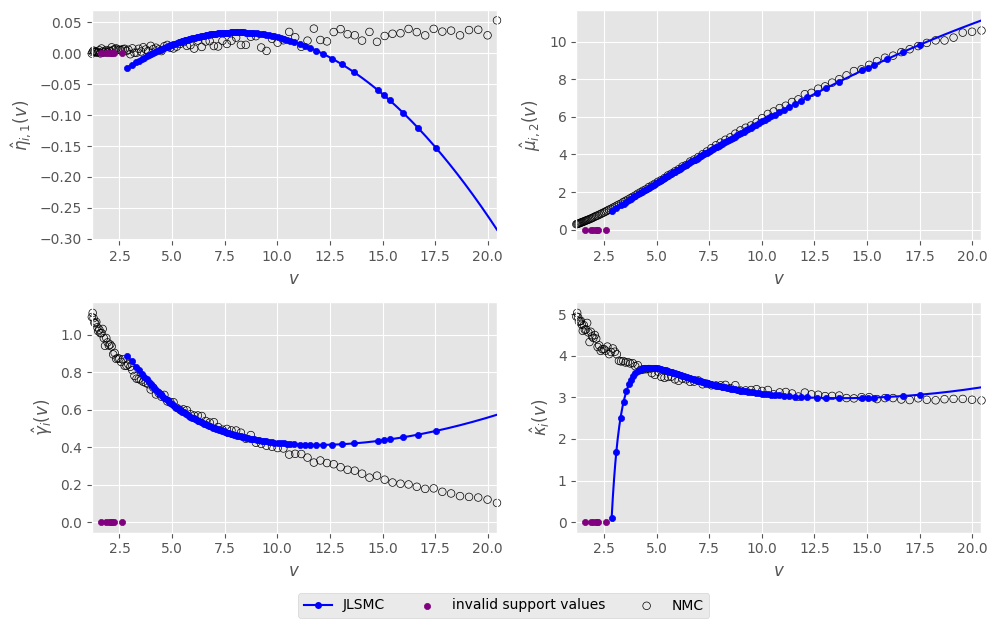

In [17]:
fig, axs    = plt.subplots(2, 2, figsize=(10, 6))
axs         = axs.flatten()

axs[0].plot(mtm_func[mask_tothat_func], murawhat_func[mask_tothat_func, 0], color=color_jlsmc, zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp], murawhat_supp[mask_tothat_supp, 0], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[0].scatter(mtm_test, muraw_test[:, 0], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\hat \\eta_{i, 1}(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_tothat_func], muhat_func[mask_tothat_func, 0], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp], muhat_supp[mask_tothat_supp, 0], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu_test[:, 0], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\hat \\mu_{i, 2}(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_tothat_func], skewhat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[2].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[2].scatter(mtm_supp[mask_tothat_supp], skewhat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[2].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\hat \\gamma_i(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))
#axs[2].set_ylim(bottom=-1)

axs[3].plot(mtm_func[mask_tothat_func], kurthat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[3].scatter(mtm_supp[mask_tothat_supp], kurthat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[3].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[3].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[3].set_xlabel('$v$')
axs[3].set_ylabel('$\\hat \\kappa_i(v)$')
axs[3].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp)}")

plt.tight_layout()
plt.show()